In [82]:
import os
import sys
sys.path.insert(0, os.path.abspath('../DropEdge/src'))

from collections import defaultdict

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm.notebook

import torch
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from sample import Sampler
from models import *
from metric import accuracy, roc_auc_compute_fn

from svd_utils import GraphConvolutionBSSVD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
args = {
    'cuda': False,
    'dataset': 'cora',
    'datapath': '../DropEdge/data/',
    'fastmode': False,
    'seed': 42,
    'epochs': 400,
    'lr': 0.01,
    'lradjust': False,
    'weight_decay': 0.005,
    'warm_start': '',
    'debug': True,
    'early_stopping': 400,
    'no_tensorboard': False,
    'normalization': 'FirstOrderGCN',
    'sampling_percent': 0.7,
    'task_type': 'full',
}

sampler = Sampler(args['dataset'], args['datapath'], args['task_type'])
labels, idx_train, idx_val, idx_test = sampler.get_label_and_idxes(cuda=args['cuda'])
nfeat = sampler.nfeat
nclass = sampler.nclass

model_args = {
    'nfeat': sampler.nfeat,
    'nclass': sampler.nclass,
    'nhid': 128,
    'nhidlayer': 1,
    'dropout': 0.8,
    'baseblock': 'mutigcn',
    'inputlayer': 'gcn',
    'outputlayer': 'gcn',
    'nbaselayer': 2,
    'activation': F.relu,
    'withbn': False,
    'withloop': False,
    'aggrmethod': 'nores',
    'mixmode': False
}

Load full supervised task.


In [33]:
def test_model(model, test_adj, test_fea):
    model.eval()
    output = model(test_fea, test_adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    return loss_test.item(), acc_test.item()

(test_adj, test_fea) = sampler.get_test_set(
    normalization=args['normalization'],
    cuda=args['cuda']
)

In [31]:
def fit_model(model, idx_train, idx_val, num_epochs=10, verbose=0):
    (train_adj, train_fea) = sampler.randomedge_sampler(
        percent=1.0,
        normalization=args['normalization'],
        cuda=args['cuda'])
    (val_adj, val_fea) = sampler.get_val_set(normalization=args['normalization'], cuda=args['cuda'])
    
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[200, 300, 400, 500, 600, 700],
                                               gamma=0.5)
    
    history = defaultdict(list)
    for ep in range(1, num_epochs+1):
        model.train()
        optimizer.zero_grad()
        output = model(train_fea, train_adj)
        
        train_loss = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        
        train_loss.backward()
        optimizer.step()
        
        history['train_loss'].append(train_loss.item())
        history['train_acc'].append(acc_train.item())
        
        # Validate
        model.eval()
        output = model(val_fea, val_adj)
        val_loss = F.nll_loss(output[idx_val], labels[idx_val]).item()
        val_acc = accuracy(output[idx_val], labels[idx_val]).item()
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if verbose > 0 and (ep % verbose == 0 or ep == num_epochs):
            print("epoch: {:3} TRAIN: acc={:.3}; loss={:.3} VALID: acc={:.3}; loss={:.3}".format(
                ep,
                acc_train.item(), train_loss.item(),
                val_acc, val_loss
            ))
            
    
        
    return history

In [47]:
def plot_history(history, test_loss=None, test_acc=None):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history['train_loss'], label='train')
    axs[0].plot(history['val_loss'], label='val')
    if test_loss:
        axs[0].axhline(test_loss, label='test after traning', color='red', linestyle="--")
    axs[0].legend()
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("loss")

    axs[1].plot(history['train_acc'], label='train')
    axs[1].plot(history['val_acc'], label='val')
    if test_acc:
        axs[1].axhline(test_acc, label='test after traning', color='red', linestyle="--")
    axs[1].legend()
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("accuracy")

epoch: 100 TRAIN: acc=0.93; loss=0.295 VALID: acc=0.858; loss=0.452
epoch: 200 TRAIN: acc=0.913; loss=0.304 VALID: acc=0.862; loss=0.47
epoch: 300 TRAIN: acc=0.911; loss=0.307 VALID: acc=0.852; loss=0.47
epoch: 400 TRAIN: acc=0.924; loss=0.276 VALID: acc=0.862; loss=0.445
epoch: 500 TRAIN: acc=0.914; loss=0.306 VALID: acc=0.852; loss=0.471
epoch: 600 TRAIN: acc=0.924; loss=0.277 VALID: acc=0.856; loss=0.489
epoch: 700 TRAIN: acc=0.91; loss=0.295 VALID: acc=0.872; loss=0.443
epoch: 800 TRAIN: acc=0.911; loss=0.282 VALID: acc=0.864; loss=0.432
TEST: acc=0.857; loss=0.528


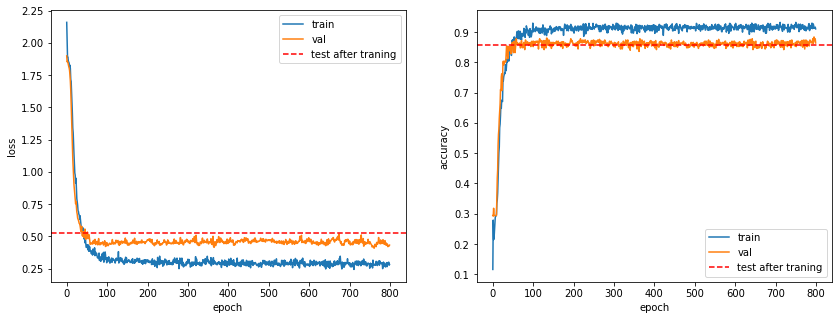

In [48]:
base_model = base_model = GCNModel(**model_args)

history = fit_model(base_model, idx_train, idx_val, num_epochs=800, verbose=100)

test_loss, test_acc = test_model(base_model, test_adj, test_fea)
print("TEST: acc={:.3}; loss={:.3}".format(test_acc, test_loss))

plot_history(history, test_loss, test_acc)

### Weight analysis

In [108]:
def multicollinearyty_det_factor(weight):
    det = np.linalg.det(weight @ weight.T)
    return det

In [130]:
layer = base_model.midlayer[0].model.hiddenlayers[0]
base_weight = layer.weight

In [131]:
det_of_wwT = multicollinearyty_det_factor(base_weight.detach().numpy())
print("Determinant of WW^T: ", det_of_wwT)

Determinant of WW^T:  -0.0


Text(0.5, 0, 'i')

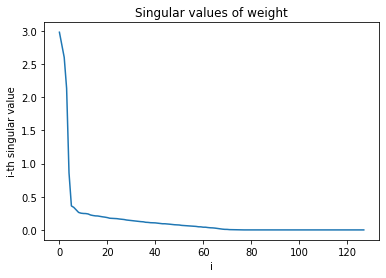

In [132]:
U, s, V = torch.svd(weight)

plt.title("Singular values of weight")
plt.plot(s.detach().numpy())
plt.ylabel("i-th singular value")
plt.xlabel("i")

In [143]:
import copy

def make_new_model(model, r):
    new_model = copy.deepcopy(model)
#     new_model.ingc = GraphConvolutionBSSVD(new_model.ingc, r)
    new_model.midlayer[0].model.hiddenlayers[0] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[0], r)
#     new_model.midlayer[0].model.hiddenlayers[1] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[1], r)
#     new_model.midlayer[0].model.hiddenlayers[2] = GraphConvolutionBSSVD(base_model.midlayer[0].model.hiddenlayers[2], r)
#     new_model.to(device)
    return new_model

In [149]:
singular_values = defaultdict(list)
for r in range(2, 31):
    new_model = make_new_model(base_model, r)
    fit_model(new_model, idx_train, idx_val, num_epochs=50, verbose=0)
    
    svd_layer = new_model.midlayer[0].model.hiddenlayers[0]
    svd_weight = torch.mm(torch.mm(svd_layer.U, torch.diag(svd_layer.s)), svd_layer.Vt).detach().numpy()
    print("r: {:2} det: {:3.3}".format(r, multicollinearyty_det_factor(svd_weight)))
    
    singular_values[r] = svd_layer.s.detach().numpy()

r:  2 det: -0.0
r:  3 det: -0.0
r:  4 det: -0.0
r:  5 det: -0.0
r:  6 det: 0.0
r:  7 det: -0.0
r:  8 det: 0.0
r:  9 det: -0.0
r: 10 det: 0.0
r: 11 det: 0.0
r: 12 det: -0.0
r: 13 det: 0.0
r: 14 det: 0.0
r: 15 det: 0.0
r: 16 det: 0.0
r: 17 det: -0.0
r: 18 det: 0.0
r: 19 det: 0.0
r: 20 det: -0.0
r: 21 det: 0.0
r: 22 det: -0.0
r: 23 det: -0.0
r: 24 det: -0.0
r: 25 det: 0.0
r: 26 det: -0.0
r: 27 det: -0.0
r: 28 det: -0.0
r: 29 det: -0.0
r: 30 det: 0.0


Text(0.5, 0, 'i')

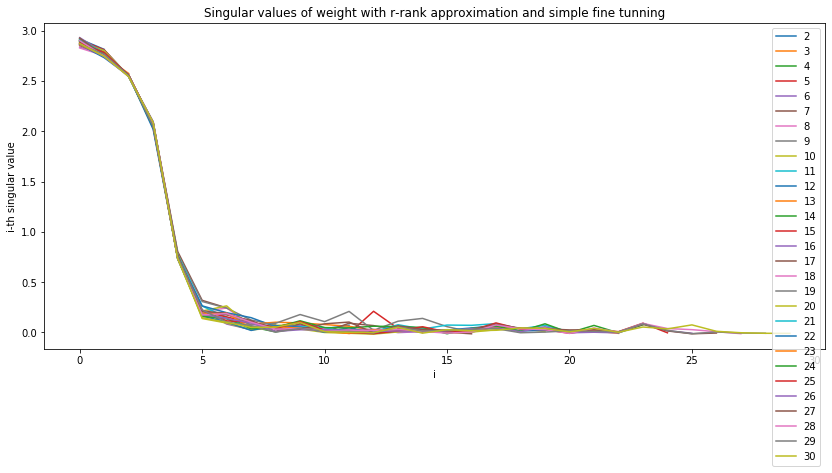

In [150]:
plt.figure(figsize=(14, 6))
plt.title("Singular values of weight with r-rank approximation and simple fine tunning")

for r in singular_values.keys():
    plt.plot(singular_values[r], label=r)
    
plt.legend()
plt.ylabel("i-th singular value")
plt.xlabel("i")